In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
base_dir = "./Data"
class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

data = []
labels = []

for gesture_class in sorted(os.listdir(base_dir)):
    gesture_folder = os.path.join(base_dir, gesture_class)

    if not os.path.isdir(gesture_folder):
        continue

    total_files = 0
    valid_files = 0

    for csv_file in os.listdir(gesture_folder):
        if csv_file.endswith(".csv"):
            total_files += 1
            file_path = os.path.join(gesture_folder, csv_file)

            # Skip empty or invalid files
            try:
                df = pd.read_csv(file_path)
                if df.empty or len(df) < 20:
                    continue  # Skip files with insufficient data
                df = df.iloc[:20]  # Ensure exactly 20 rows
            except pd.errors.EmptyDataError:
                continue  # Skip empty files

            valid_files += 1

            # Drop the frame_number and landmark_number columns
            df_processed = df.drop(df.columns[[0] + list(range(1, df.shape[1], 4))], axis=1)

            np_data = df_processed.to_numpy()

            data.append(np_data)

            labels.append(gesture_class)

    print(f"Class '{gesture_class}': Original files = {total_files}, Valid files = {valid_files}")

data_tensor = torch.tensor(np.array(data), dtype=torch.float32)
labels_tensor = torch.tensor(pd.Categorical(labels).codes, dtype=torch.long)

print("Data tensor shape:", data_tensor.shape)
print("Labels tensor shape:", labels_tensor.shape)

Class 'Doing other things': Original files = 2511, Valid files = 930
Class 'Shaking Hand': Original files = 1083, Valid files = 552
Class 'Sliding Two Fingers Down': Original files = 1119, Valid files = 157
Class 'Sliding Two Fingers Left': Original files = 1113, Valid files = 182
Class 'Sliding Two Fingers Right': Original files = 1065, Valid files = 150
Class 'Sliding Two Fingers Up': Original files = 1059, Valid files = 315
Class 'Swiping Down': Original files = 4871, Valid files = 760
Class 'Swiping Left': Original files = 4726, Valid files = 660
Class 'Swiping Right': Original files = 4687, Valid files = 603
Class 'Swiping Up': Original files = 4821, Valid files = 876
Class 'Thumb Down': Original files = 1506, Valid files = 499
Class 'Thumb Up': Original files = 1428, Valid files = 319
Class 'Turning Hand Clockwise': Original files = 1018, Valid files = 524
Class 'Turning Hand Counterclockwise': Original files = 1151, Valid files = 589
Class 'Zooming In With Full Hand': Original f

In [85]:
samples, frames, features = data_tensor.shape

data_reshaped = data_tensor.reshape(-1, features)

scaler = StandardScaler()
data_tensor_scaled = scaler.fit_transform(data_tensor.reshape(-1, features))

data_tensor = torch.tensor(data_tensor.reshape(samples, frames, features), dtype=torch.float32)

C:\Users\stone\AppData\Local\Temp\ipykernel_2748\464334366.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data_tensor.reshape(samples, frames, features), dtype=torch.float32)


In [86]:
X_train, X_temp, y_train, y_temp = train_test_split(
    data_tensor, labels_tensor, test_size=0.3, stratify=labels_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [87]:
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [88]:
import torch
import torch.nn as nn

class GestureRecognitionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GestureRecognitionModel, self).__init__()

        # BiLSTM with Layer Normalization
        self.bilstm = nn.LSTM(input_size=input_size, hidden_size=256, num_layers=2, 
                              batch_first=True, bidirectional=True)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        
        # Residual connection
        self.residual_fc = nn.Linear(input_size, 512)

        # Dropout
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        
        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(512, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)

        # Activation functions
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        
        attention_weights = self.attention(lstm_out)
        attention_weights = attention_weights.permute(0, 2, 1)
        
        weighted_lstm_out = torch.bmm(attention_weights, lstm_out).squeeze(1)

        x_residual = self.residual_fc(x[:, -1, :])
        x = weighted_lstm_out + x_residual
        
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)

        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc3(x)
        return x


In [ ]:
input_size = X_train.shape[2]
num_classes = len(torch.unique(labels_tensor))

model = GestureRecognitionModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print(model)

GestureRecognitionModel(
  (bilstm): LSTM(63, 256, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (residual_fc): Linear(in_features=63, out_features=512, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=18, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
)


Epoch [1/40], Loss: 2.1740, Error: 0.6254
Validation Loss: 1.4808, Validation Error: 0.4214
Validation loss improved. Saving model...
Epoch [2/40], Loss: 1.3594, Error: 0.3578
Validation Loss: 1.0231, Validation Error: 0.2648
Validation loss improved. Saving model...
Epoch [3/40], Loss: 1.0610, Error: 0.2877
Validation Loss: 0.8690, Validation Error: 0.2250
Validation loss improved. Saving model...
Epoch [4/40], Loss: 0.8865, Error: 0.2426
Validation Loss: 0.7016, Validation Error: 0.2011
Validation loss improved. Saving model...
Epoch [5/40], Loss: 0.7809, Error: 0.2156
Validation Loss: 0.6911, Validation Error: 0.1991
Validation loss improved. Saving model...
Epoch [6/40], Loss: 0.7217, Error: 0.2049
Validation Loss: 0.6266, Validation Error: 0.1871
Validation loss improved. Saving model...
Epoch [7/40], Loss: 0.7027, Error: 0.1965
Validation Loss: 0.5561, Validation Error: 0.1599
Validation loss improved. Saving model...
Epoch [8/40], Loss: 0.6553, Error: 0.1860
Validation Loss: 0.5

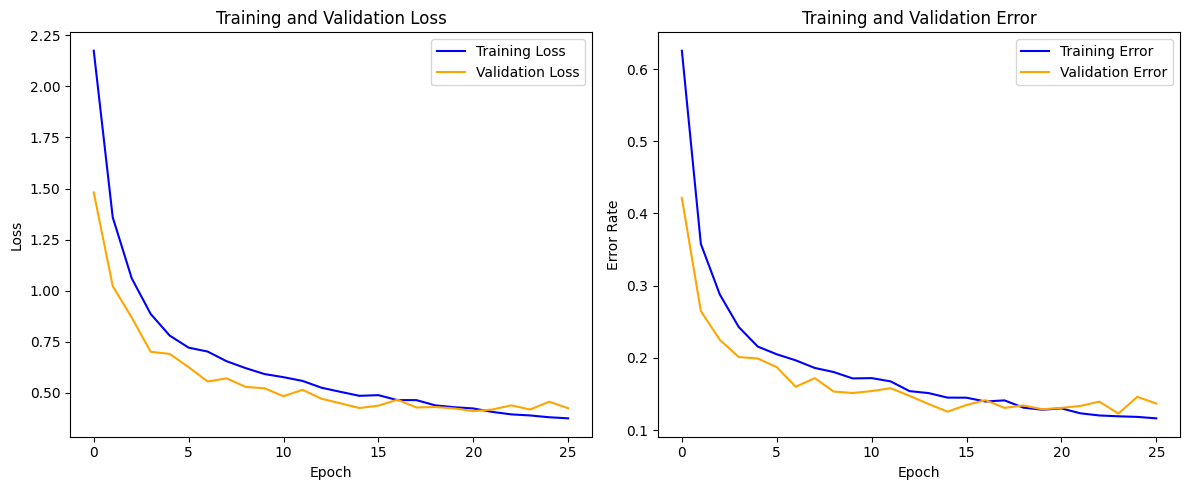

In [90]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

num_epochs = 40
train_losses = []
val_losses = []
train_errors = []
val_errors = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training error
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_error = 1 - train_accuracy
    train_losses.append(avg_loss)
    train_errors.append(train_error)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Error: {train_error:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation error
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_error = 1 - val_accuracy
    val_losses.append(avg_val_loss)
    val_errors.append(val_error)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Error: {val_error:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
        print("Validation loss improved. Saving model...")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")
        
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            early_stop = True
            break

# Restore the best model if early stopping was triggered
if early_stop:
    model.load_state_dict(best_model_state)
    print("Loaded the best model from saved state.")

# Plotting training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_errors, label='Training Error', color='blue')
plt.plot(val_errors, label='Validation Error', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.title('Training and Validation Error')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully!")


Model saved successfully!


Classification Report:
                                precision    recall  f1-score   support

           Doing other things   0.836066  0.733813  0.781609       139
                 Shaking Hand   0.771739  0.855422  0.811429        83
     Sliding Two Fingers Down   0.952381  0.869565  0.909091        23
     Sliding Two Fingers Left   0.960000  0.857143  0.905660        28
    Sliding Two Fingers Right   0.958333  1.000000  0.978723        23
       Sliding Two Fingers Up   0.977778  0.936170  0.956522        47
                 Swiping Down   0.858268  0.956140  0.904564       114
                 Swiping Left   0.805825  0.838384  0.821782        99
                Swiping Right   0.863636  0.626374  0.726115        91
                   Swiping Up   0.871429  0.924242  0.897059       132
                   Thumb Down   0.986301  0.960000  0.972973        75
                     Thumb Up   0.884615  0.958333  0.920000        48
       Turning Hand Clockwise   0.813333  0.782051  

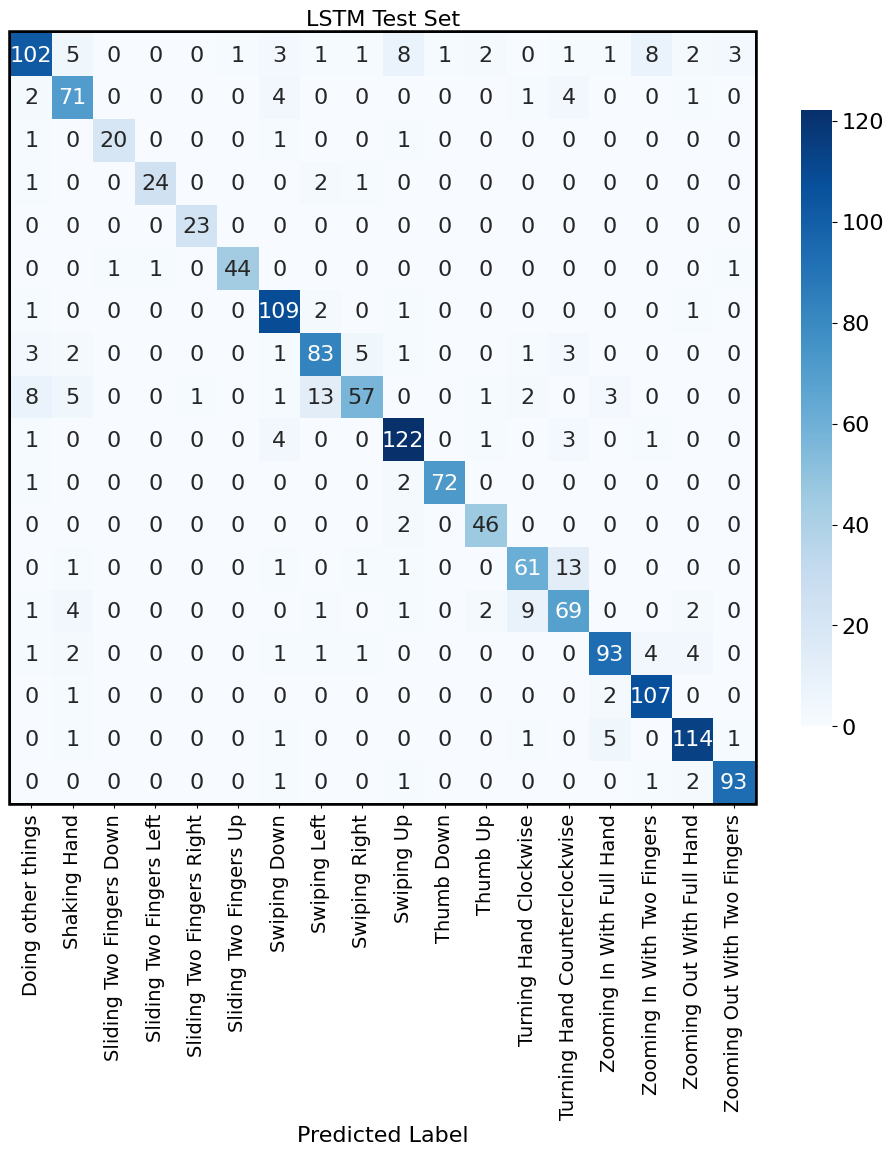

In [ ]:
# Evaluation on Test Set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=6))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", 
    xticklabels=class_names, yticklabels=class_names, 
    annot_kws={"size": 16}, cbar_kws={"shrink": 0.8}
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

ax.patch.set_edgecolor('black')  

ax.patch.set_linewidth(4)  

plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('LSTM Test Set', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()
